In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import glob
import data_loading
import eval
import partitioning
import impact


In [45]:
# root_path="/homes/80/kang/lob_bench/GOOG_small/"
root_path="/homes/80/kang/lob_bench/GOOG/"
# root_path="/data1/sascha/data/GOOG/"




loader = data_loading.Simple_Loader(
            real_data_path= root_path+"data_real",
            gen_data_path = root_path+"data_gen",
            cond_data_path=root_path+"data_cond",
)

## do the filtering of error messages

In [5]:
def ob3Drepr(orderbook, row_index):
    '''
    Input is the orderbook, for example, `b_real`, `b_gene`, and the corresponding `row_index`. 
    Output is the 3D reconstruction of the row in the orderbook corresponding to `row_index`.
    delta_mid_price: delta mid-price
    index:           relative price level where change occurs,
    quant:           change in quantity at that level
    '''
    price_level = 10
    delta_mid_price = orderbook.iloc[row_index,-1]
    lb_array=orderbook.iloc[row_index-1,:4*price_level].values.reshape(2*price_level,2)
    b_array=orderbook.iloc[row_index,:4*price_level].values.reshape(2*price_level,2)
    lb_unique = np.array([x for x in lb_array if not any(np.array_equal(x, y) for y in b_array)])
    b_unique = np.array([x for x in b_array if not any(np.array_equal(x, y) for y in lb_array)])
    if len(lb_unique) == len(b_unique) == 0: return np.array([0,0,0])
    if len(lb_unique) != 0 and len(b_unique) == 0: 
        index = np.where((lb_array == lb_unique[0]).all(axis=1))[0][0]
        return np.array([delta_mid_price, index, -lb_unique[0][1]])
    if len(lb_unique) == 0 and len(b_unique) != 0: 
        index = np.where((b_array == b_unique[0]).all(axis=1))[0][0]
        return np.array([delta_mid_price, index, b_unique[0][1]])
    first_lb_unique=lb_unique[0];first_b_unique=b_unique[0]
    index = np.where(b_array[:, 0] == first_b_unique[0])[0][0]
    quant = np.where(first_b_unique[0] == first_lb_unique[0], first_b_unique[1] - first_lb_unique[1], first_b_unique[1])
    result = np.array([delta_mid_price,index,quant])
    return result

In [44]:
def filtering_b_gen(orderbook):
    error_row_indices=  []
    for row_index in range(1,orderbook.shape[0]):
        price_level = 10
        delta_mid_price = orderbook.iloc[row_index,-1]
        lb_array=orderbook.iloc[row_index-1,:4*price_level].values.reshape(2*price_level,2)
        b_array=orderbook.iloc[row_index,:4*price_level].values.reshape(2*price_level,2)
        if (lb_array == b_array).all():
            error_row_indices.append(row_index)
    valid_indices = [i for i in orderbook.index if i not in error_row_indices]
    orderbook = orderbook.loc[valid_indices]
    return orderbook

In [46]:
import ray
import numpy as np
from tqdm import tqdm

ray.shutdown()
# Initialize Ray
ray.init(num_cpus=32,object_store_memory=40*10**9)


# Define a remote function for processing each element
@ray.remote
def process_element(b_real, b_gen):
    b_gen = filtering_b_gen(b_gen)
    b_real_arr = np.array([ob3Drepr(b_real, i) for i in range(1, b_real.shape[0])])
    b_gen_arr = np.array([ob3Drepr(b_gen, i) for i in range(1, b_gen.shape[0])])
    return [b_real_arr, b_gen_arr]

# Initialize an empty list to store results
lst = []

# Collect remote function calls
futures = []
for s in tqdm(loader):
    b_real = s.b_real
    b_gen = s.b_gen[0]
    futures.append(process_element.remote(b_real, b_gen))

# Gather results from Ray
# lst = ray.get(futures)

lst = [future for future in tqdm(ray.get(futures), total=len(futures))]


# Optionally, shutdown Ray if done with all tasks
ray.shutdown()

# Now lst contains the processed results
print(lst)


2024-06-05 16:55:52,566	INFO worker.py:1749 -- Started a local Ray instance.
100%|██████████| 3136/3136 [00:00<00:00, 4255366.34it/s]


[[array([[1105,    3,   25],
       [1105,   11,  -18],
       [1105,   11,  100],
       ...,
       [1105,    0,  100],
       [1105,    0,  100],
       [1105,    0,   20]]), array([[1205,   19,  100],
       [1105,   19, -100],
       [1105,    7,  200],
       ...,
       [ 218,   12,  100],
       [ 218,   11, -100],
       [ 218,   15, -100]])], [array([[354,  19,  50],
       [354,   1, 100],
       [354,   0, 800],
       ...,
       [454,  11,  -5],
       [454,   3, -44],
       [454,   1,  -2]]), array([[ 429,    0, -100],
       [ 429,    4, -100],
       [ 429,    6,  100],
       ...,
       [ 681,    6, -100],
       [ 681,   15,  100],
       [ 681,    9,  100]])], [array([[ 405,    8,  -93],
       [ 405,    6,   93],
       [ 405,    6,  100],
       ...,
       [ 516,    8,  100],
       [ 516,    0, -100],
       [ 516,   13,  100]]), array([[  50,    8,  100],
       [  50,    4, -100],
       [  50,    2,  100],
       ...,
       [ 851,    0,    1],
       [ 851

In [47]:
np.array([(real.shape[0],gene.shape[0]) for real,gene in lst]).min(axis=0)
print(np.quantile(np.array([(real.shape[0],gene.shape[0]) for real,gene in lst]),0.05,axis=0))
arr=np.array([(real.shape[0],gene.shape[0]) for real,gene in lst])
arr,len(lst)

[499. 476.]


(array([[499, 490],
        [499, 494],
        [499, 481],
        ...,
        [499, 499],
        [499, 496],
        [499, 497]]),
 3136)

In [58]:
length = 480
selected_elements = [lst[i] for i in np.where(arr[:, 1] > length)[0]]
len(selected_elements)

2857

In [59]:
reals = [real[:length,:] for real, gene in selected_elements]
genes = [gene[:length,:] for real, gene in selected_elements]
len(reals),len(genes)

(2857, 2857)

In [60]:
real_data = np.array(reals)
fake_data = np.array(genes)
num_sampels = fake_data.shape[0]
num_sampels,fake_data.shape
# np.array(reals).shape

(2857, (2857, 480, 3))

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, recall_score, precision_score

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x
    
class CNNModel(nn.Module):
    def __init__(self, input_size, num_channels=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * (input_size // 4), 128)  
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Switch dimensions to (batch, channels, time_steps)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    
class CNNModelWithAttention(nn.Module):
    def __init__(self, input_size, num_channels=3, attention_heads=8, attention_dim=64):
        super(CNNModelWithAttention, self).__init__()

        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.attention = nn.MultiheadAttention(
            embed_dim=attention_dim,  # The dimension of the attention embeddings
            num_heads=attention_heads,  # Number of attention heads
            batch_first=True  # Indicates that the input data has batch dimension first
        )

        # Calculate output size after convolutions and pooling
        reduced_size = input_size // 4
        self.fc1 = nn.Linear(64 * reduced_size, 128)  
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Apply attention to the convolutional output
        x = x.permute(0, 2, 1)  # Back to (batch, time_steps, channels)
        x, _ = self.attention(x, x, x)  # Self-attention
        x = x.permute(0, 2, 1)  # Back to (batch, channels, time_steps)

        # Calculate new reduced size after attention
        new_reduced_size = x.shape[2] // 4
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, writer, epochs=100):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        for sequences, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(sequences)  # Pass sequences directly to the model
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_dataloader)
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation loop (with recall calculation)
        model.eval()
        val_loss = 0.0
        all_val_labels = []
        all_val_predictions = []
        with torch.no_grad():
            for sequences, labels in val_dataloader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.tolist())
                all_val_predictions.extend(predicted.tolist())

        avg_val_loss = val_loss / len(val_dataloader)
        val_recall = recall_score(all_val_labels, all_val_predictions, average='binary')  # Calculate recall
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
        
        # Calculate metrics
        val_precision = precision_score(all_val_labels, all_val_predictions, average='binary')
        val_recall = recall_score(all_val_labels, all_val_predictions, average='binary')
        val_f1 = f1_score(all_val_labels, all_val_predictions, average='binary')
        
        writer.add_scalar('Precision/validation', val_precision, epoch)
        writer.add_scalar('Recall/validation', val_recall, epoch)
        writer.add_scalar('F1/validation', val_f1, epoch)


        model.train()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Recall: {val_recall:.4f}")

def infer(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = sequence.view(sequence.size(0), -1)  # Flatten the input sequence
        output = model(sequence)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Assume input_size is the length of the sequence
input_size = 480 * 3  # Adjusted for the new dimension
input_size_cnn = 480  # Adjusted for the new dimension


# Generate some random data for demonstration purposes
real_data = torch.tensor(real_data, dtype=torch.float32)
fake_data = torch.tensor(fake_data, dtype=torch.float32)

# Generate labels
num_samples = real_data.size(0)
real_labels = torch.ones(num_samples, dtype=torch.long)  
fake_labels = torch.zeros(num_samples, dtype=torch.long)  
# Combine data and labels
data = torch.cat((real_data, fake_data), dim=0)
labels = torch.cat((real_labels, fake_labels), dim=0)

indices = torch.randperm(data.size(0))  
data = data[indices]
labels = labels[indices]



# Create dataset and dataloader
dataset = TensorDataset(data, labels)
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=2600, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=2600)
test_dataloader = DataLoader(test_dataset, batch_size=2600)

# Initialize model, loss function, optimizer, and TensorBoard writer
model = CNNModelWithAttention(input_size_cnn)
# model = CNNModel(input_size_cnn)
# model = SimpleNN(input_size)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
writer = SummaryWriter()  # Initialize TensorBoard writer

# Train the model
# train_model(model, train_dataloader, val_dataloader, criterion, optimizer, writer, epochs=5)
# train_model(model, train_dataloader, val_dataloader, criterion, optimizer, writer, epochs=5000)
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, writer, epochs=150)

# Evaluate the model on the test set (Corrected)
model.eval()
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for sequences, labels in test_dataloader:
        outputs = model(sequences)  # Pass sequences directly
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

avg_test_loss = test_loss / len(test_dataloader)
writer.add_scalar('Loss/test', avg_test_loss)

# Calculate F1 score and Recall
f1 = f1_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Close the TensorBoard writer
writer.close()

/homes/80/kang/anaconda3/envs/lob_bench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/150, Train Loss: 26.7058, Val Loss: 24.1061, Val Recall: 0.0000
Epoch 2/150, Train Loss: 15.1808, Val Loss: 5.0758, Val Recall: 0.9900
Epoch 3/150, Train Loss: 7.5230, Val Loss: 8.5636, Val Recall: 1.0000
Epoch 4/150, Train Loss: 8.6513, Val Loss: 5.0362, Val Recall: 1.0000
Epoch 5/150, Train Loss: 4.6411, Val Loss: 0.9861, Val Recall: 0.7963
Epoch 6/150, Train Loss: 1.9630, Val Loss: 2.1319, Val Recall: 0.0014
Epoch 7/150, Train Loss: 2.1057, Val Loss: 1.6775, Val Recall: 0.0000
Epoch 8/150, Train Loss: 1.3704, Val Loss: 0.8950, Val Recall: 0.2869
Epoch 9/150, Train Loss: 0.7892, Val Loss: 0.7805, Val Recall: 0.9125
Epoch 10/150, Train Loss: 0.7239, Val Loss: 0.7536, Val Recall: 0.9656
Epoch 11/150, Train Loss: 0.6820, Val Loss: 0.7264, Val Recall: 0.9742
Epoch 12/150, Train Loss: 0.7114, Val Loss: 0.7000, Val Recall: 0.9828
Epoch 13/150, Train Loss: 0.6812, Val Loss: 0.6987, Val Recall: 0.8350
Epoch 14/150, Train Loss: 0.6721, Val Loss: 0.6898, Val Recall: 0.9857
Epoch 15/150

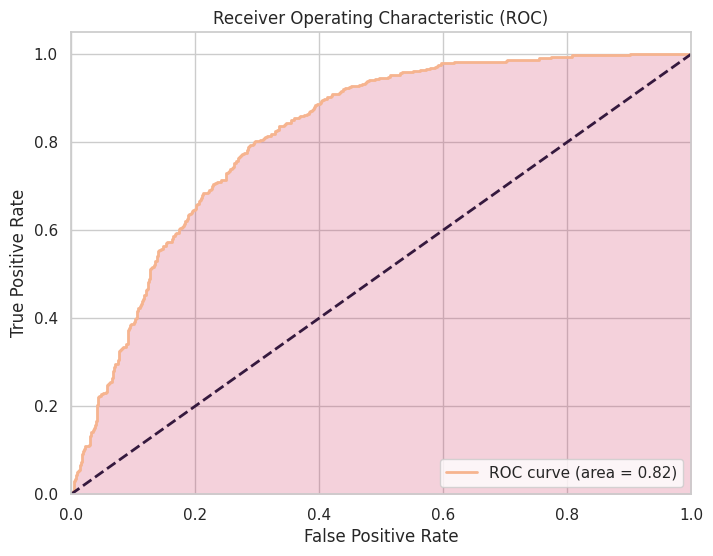

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# ROC Curve Plotting (for Test Set)
model.eval()
test_probs = []  
test_labels = []  

with torch.no_grad():
    for sequences, labels in test_dataloader:
        outputs = model(sequences)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Seaborn Styling and Color Palette
sns.set_theme(style="whitegrid")  # Set Seaborn theme
palette = sns.color_palette("rocket")  # "rocket" color palette
cmap = sns.color_palette("rocket", as_cmap=True)  # Colormap for the ROC curve line

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=palette[-1], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  
plt.plot([0, 1], [0, 1], color=palette[0], lw=2, linestyle='--')  
plt.fill_between(fpr, tpr, color=cmap(0.5), alpha=0.2)  # Fill area under ROC curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
